# Comparison of Tumor and Non-Tumor Datasets
In our spatial transcriptomics dataset, we analyzed samples from colorectal carcinoma patients, including tissue from different regions (rectum, colon, and cecum). Most samples originate from carcinoma tissue, while one patient's data comes from non-neoplastic tissue.

In this notebook:
- we aim to compare **tumor and non-tumor datasets** to identify genes exhibiting significant differential spatial variability (SVGs). 
- we will examine **q-values** and **log-likelihood ratios (LLR)**, identify shared and unique genes, and visualize their overlaps and counts. 


## 1. Import Libraries
We import the necessary Python libraries for data manipulation and visualization.
- `pandas` for handling tabular data  
- `matplotlib` for plotting  
- `matplotlib_venn` to visualize overlaps of gene sets  
- `scipy.stats.spearmanr` to compute correlations between tumor and non-tumor values


In [342]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
from scipy.stats import spearmanr


## 2. Set Parameters

Define thresholds for filtering significant genes:  
- **q-value threshold (`q_thr`)**: significance level for spatial variability  
- **LLR threshold (`llr_thr`)**: minimal effect size  

Filtering genes based on these thresholds helps us focus on **meaningful differences** between tumor and non-tumor samples.


In [343]:
q_thr = 0.05
llr_thr = 1

## 3. Load Data

We load SOMDE results for each replicate of tumor and non-tumor samples.  
We have multiple replicates to account for **biological variability** and improve reliability of our results.



In [344]:
base_path = "somde_results"

# Non-tumor replicates
A798015_rep1_nontumor = pd.read_csv(f"{base_path}/SN123_A798015_Rep1/somde_result.csv")
A798015_rep2_nontumor = pd.read_csv(f"{base_path}/SN124_A798015_Rep2/somde_result.csv")

# Tumor replicates
A121573_rep1_tumor = pd.read_csv(f"{base_path}/SN048_A121573_Rep1/somde_result.csv")
A121573_rep2_tumor = pd.read_csv(f"{base_path}/SN048_A121573_Rep2/somde_result.csv")
A938797_rep1_tumor = pd.read_csv(f"{base_path}/SN123_A938797_Rep1_X/somde_result.csv")
A938797_rep2_tumor = pd.read_csv(f"{base_path}/SN124_A938797_Rep2/somde_result.csv")



## 4. Combine Replicates
Concatenate replicates into a single dataframe for non-tumor and tumor samples.


In [345]:
A798015_nontumor = pd.concat([A798015_rep1_nontumor, A798015_rep2_nontumor], ignore_index=True)
A121573_tumor = pd.concat([A121573_rep1_tumor, A121573_rep2_tumor], ignore_index=True)
A938797_tumor = pd.concat([A938797_rep1_tumor, A938797_rep2_tumor], ignore_index=True)


## 5. Filter Significant Genes

We keep only genes that satisfy:  
- **q-value < `q_thr`** (statistically significant spatial variability)  
- **LLR > `llr_thr`** (effect size threshold)

This ensures we focus on **robust SVGs** that are likely biologically meaningful.



In [346]:
A798015_nontumor = A798015_nontumor[
    (A798015_nontumor["qval"] < q_thr) &
    (A798015_nontumor["LLR"]  > llr_thr)
]

A121573_tumor = A121573_tumor[
    (A121573_tumor["qval"] < q_thr) &
    (A121573_tumor["LLR"]  > llr_thr)
]

A938797_tumor = A938797_tumor[
    (A938797_tumor["qval"] < q_thr) &
    (A938797_tumor["LLR"]  > llr_thr)
]

## 6. Aggregate Genes Across Replicates

For each gene, we take:  
- **minimum q-value**   
- **maximum LLR**  

This step consolidates replicate information and ensures **one value per gene** for further comparisons.



In [347]:
A121573_tumor = (
    A121573_tumor
    .groupby("g", as_index=False)
    .agg(
        qval_min=("qval", "min"),
        LLR_max=("LLR", "max")
    )
)

A938797_tumor = (
    A938797_tumor
    .groupby("g", as_index=False)
    .agg(
        qval_min=("qval", "min"),
        LLR_max=("LLR", "max")
    )
)

A798015_nontumor = (
    A798015_nontumor
    .groupby("g", as_index=False)
    .agg(
        qval_min=("qval", "min"),
        LLR_max=("LLR", "max")
    )
)


## 7. Identify Shared and Unique SVG Genes
We categorize genes into:  
- **Tumor-shared:** present in both tumor datasets  
- **Tumor-unique:** only in tumor datasets  
- **Non-tumor-unique:** only in non-tumor dataset  

This helps us understand which genes are **specific to tumors** and which are common across conditions.



In [348]:
svg_t1 = set(A121573_tumor["g"])
svg_t2 = set(A938797_tumor["g"])
svg_nt = set(A798015_nontumor["g"])

tumor_shared = svg_t1.intersection(svg_t2)
tumor_all = svg_t1.union(svg_t2)
tumor_unique = tumor_all.difference(svg_nt)
nontumor_unique = svg_nt.difference(tumor_all)

## 8. Venn Diagram of SVG Genes
We visualize the overlap of genes between tumor replicates and non-tumor samples.  
This provides an **intuitive understanding** of shared vs unique genes.


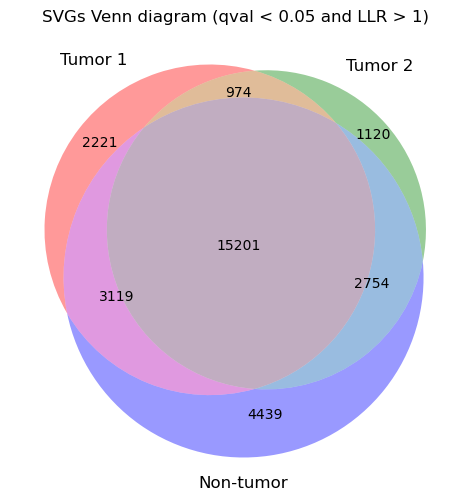

In [349]:
plt.figure(figsize=(6,6))
venn3([svg_t1, svg_t2, svg_nt], 
      set_labels=("Tumor 1", "Tumor 2", "Non-tumor"))
plt.title("SVGs Venn diagram (qval < 0.05 and LLR > 1)")
plt.show()

## 9. Gene Count Comparison

We display the number of **shared and unique genes** using a bar plot.  
This summary highlights the **extent of tumor-specific vs non-tumor-specific SVGs**, helping to identify potentially interesting targets for further study.


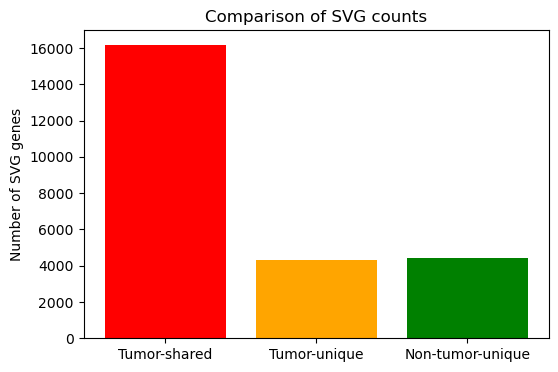

{'Tumor-shared': 16175, 'Tumor-unique': 4315, 'Non-tumor-unique': 4439}


In [350]:
counts = {
    "Tumor-shared": len(tumor_shared),
    "Tumor-unique": len(tumor_unique),
    "Non-tumor-unique": len(nontumor_unique)
}

plt.figure(figsize=(6,4))
plt.bar(counts.keys(), counts.values(), color=["red", "orange", "green"])
plt.ylabel("Number of SVG genes")
plt.title("Comparison of SVG counts")
plt.show()

print(counts)


## 10. Combine Tumor Data
We merge the tumor datasets and take **minimum q-values** and **maximum LLR** for each gene.  
This ensures we have a **single representative value per gene** for downstream comparisons.


In [351]:
tumor1_common = A121573_tumor[A121573_tumor["g"].isin(tumor_shared)].set_index("g")
tumor2_common = A938797_tumor[A938797_tumor["g"].isin(tumor_shared)].set_index("g")

tumor1_common = A121573_tumor[A121573_tumor["g"].isin(tumor_shared)].set_index("g")
tumor2_common = A938797_tumor[A938797_tumor["g"].isin(tumor_shared)].set_index("g")

combined = (
    pd.concat([
        tumor1_common.loc[list(tumor_shared)],
        tumor2_common.loc[list(tumor_shared)]
    ])
    .groupby(level=0)
    .min()
)

combined_svg = combined.index
print("Number of combined tumor SVG genes:", len(combined_svg))

combined_svg_sorted = combined_svg.sort_values()

Number of combined tumor SVG genes: 16175


## 11. Select Non-Tumor Genes Shared with Tumors
We select non-tumor genes that are also present in tumor datasets.  
This allows **direct comparison** of tumor and non-tumor gene behavior for the same set of genes.

In [352]:
nontumor_common = A798015_nontumor[A798015_nontumor["g"].isin(combined_svg_sorted)].set_index("g")
common_genes_all = set(combined_svg_sorted).intersection(nontumor_common.index)
common_genes_all = sorted(common_genes_all)

## 12. Extract q-values and LLR into Numpy Arrays

We extract **q-values** and **LLR** for shared genes into numpy arrays, preparing for **correlation analysis** between tumor and non-tumor datasets.


In [353]:
scores_tumor_common = combined.loc[common_genes_all, "qval_min"].to_numpy()
scores_nontumor_common = nontumor_common.loc[common_genes_all, "qval_min"].values

LLR_tumor_common = combined.loc[common_genes_all, "LLR_max"].to_numpy()
LLR_nontumor_common = nontumor_common.loc[common_genes_all, "LLR_max"].values

print(scores_tumor_common)
print(scores_nontumor_common)
print(LLR_tumor_common)
print(LLR_nontumor_common)

[9.84344908e-09 0.00000000e+00 0.00000000e+00 ... 5.55994848e-06
 0.00000000e+00 0.00000000e+00]
[0.         0.         0.         ... 0.00047585 0.         0.        ]
[36.81926644 38.12473257 30.08560216 ... 20.37740567 30.08560216
 30.08560216]
[ 81.52292154 151.42338589 137.89417235 ...  13.24277493 248.97073907
 248.97073907]


## 13. Spearman Correlation
We calculate Spearman correlation between tumor and non-tumor genes:  
- **LLR correlation:** measures log-likelihood ratio similarity  
- **q-value correlation:** measures statistical significance similarity  

High correlation indicates **similar patterns** between tumor and non-tumor conditions.



In [354]:
corr_llr, pval_llr = spearmanr(LLR_tumor_common, LLR_nontumor_common)
print("Spearman correlation between tumor and non-tumor LLR:", corr_llr)
print(f"p-value: {pval_llr:.3e}")

corr_Q, pval_Q = spearmanr(scores_tumor_common, scores_nontumor_common)
print("Spearman correlation between tumor and non-tumor qval:", corr_Q)
print(f"p-value: {pval_Q:.3e}")

Spearman correlation between tumor and non-tumor LLR: 0.41593433091416593
p-value: 0.000e+00
Spearman correlation between tumor and non-tumor qval: 0.716327575176577
p-value: 0.000e+00


While the significance of spatially variable genes (q-values) is fairly consistent between tumor and non-tumor tissue, the magnitude of spatial variability (LLR) is only moderately correlated. This could mean that some genes show significant spatial patterns in both conditions, but the strength of these patterns differs between tumor and non-tumor tissue.

### Scatter Plot: LLR Tumor vs Non-Tumor

We visualize the log-likelihood ratio (LLR) values for shared genes between tumor and non-tumor datasets.  

Each point represents a gene, with the **Tumor LLR** on the x-axis and the **Non-tumor LLR** on the y-axis.  
The dashed red line (y = x) helps to see how closely the values match: points near the line indicate similar LLR in both conditions.  

This plot helps us understand how the **LLR** differs between tumor and non-tumor tissue.


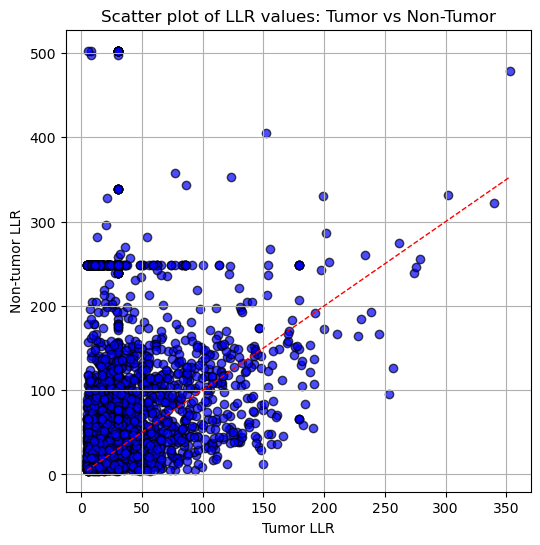

In [357]:
plt.figure(figsize=(6,6))
plt.scatter(LLR_tumor_common, LLR_nontumor_common, alpha=0.7, color='blue', edgecolor='k')
plt.xlabel("Tumor LLR")
plt.ylabel("Non-tumor LLR")
plt.title("Scatter plot of LLR values: Tumor vs Non-Tumor")
plt.grid(True)

# Optionally, add a y=x reference line
plt.plot([min(LLR_tumor_common), max(LLR_tumor_common)],
         [min(LLR_tumor_common), max(LLR_tumor_common)],
         color='red', linestyle='--', linewidth=1)

plt.show()

### Scatter Plot: q-values Tumor vs Non-Tumor

We visualize the q-values for shared genes between tumor and non-tumor datasets.  

Each point represents a gene, with the **Tumor q-value** on the x-axis and the **Non-tumor q-value** on the y-axis.  
The dashed red line (y = x) shows genes with similar statistical significance in both conditions.  

This plot helps us understand how the **q-value** differs between tumor and non-tumor tissue.


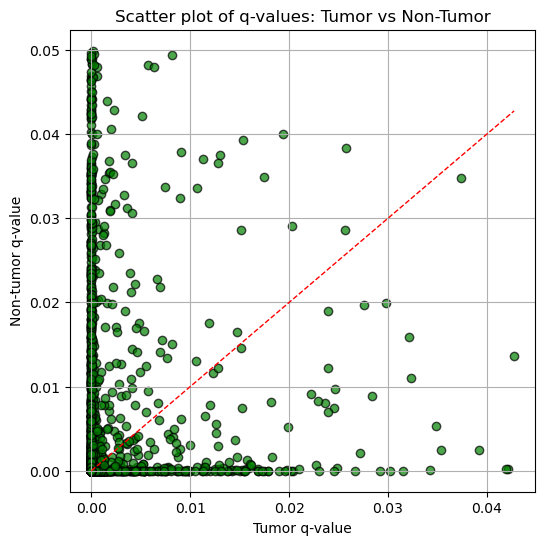

In [358]:
plt.figure(figsize=(6,6))
plt.scatter(scores_tumor_common, scores_nontumor_common, alpha=0.7, color='green', edgecolor='k')
plt.xlabel("Tumor q-value")
plt.ylabel("Non-tumor q-value")
plt.title("Scatter plot of q-values: Tumor vs Non-Tumor")
plt.grid(True)

# Optionally, add a y=x reference line
plt.plot([min(scores_tumor_common), max(scores_tumor_common)],
         [min(scores_tumor_common), max(scores_tumor_common)],
         color='red', linestyle='--', linewidth=1)

plt.show()